In [1]:
#Ｉmport necessary packages
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import xitorch
from xitorch.optimize import rootfinder
import optuna
from torch.utils.data import TensorDataset, DataLoader
import joblib 
import torch.optim as optim

# Different Potentials with D correction
from FrictionNNModels import PotentialsFricCorrection, Loss, train1Epoch, PP, ReLUSquare, PotsCalXiXiDot

# Memory management on GPU
import gc

# Import time
import time

# Testify whether GPU is available
print("Cuda is available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("Device is: ", device)

def memory_stats():
    print("Memory allocated: ", torch.cuda.memory_allocated()/1024**2)
    print("Memory cached: ", torch.cuda.memory_reserved()/1024**2)
memory_stats()

/home/shengduo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Cuda is available:  True
Device is:  cuda:0
Memory allocated:  0.0
Memory cached:  0.0


In [2]:
# Import the learnt potentials
# modelPrefix = "Trial0112_combined"
modelPrefix = "Trial0112_smallDRS_smallA"
dim_xi = 1
myModel = torch.load("./model/{0}_dimXi_{1}.pth".format(modelPrefix, dim_xi))

In [3]:
# Import data
dataPrefix = "Trial0112_combined"
shit = torch.load("./data/{0}.pt".format(dataPrefix))
Vs = shit["Vs"]
thetas = shit["thetas"]
fs = shit["fs"]
ts = shit["ts"]

# Now Vs and ts have fixed length
print("Vs.shape: ", Vs.shape)
print("thetas.shape: ", thetas.shape)
print("fs.shape: ", fs.shape)
print("ts.shape: ", ts.shape)

# Calculate Xs
Xs = torch.zeros(Vs.shape)
Xs[:, 1:] = torch.cumulative_trapezoid(Vs, ts)
print("Xs.shape: ", Xs.shape)

# Calculate xis, xiDots trajectories
myPotCal = PotsCalXiXiDot(myModel)
myPotCal.calf(Xs, Vs, ts)
xis = myPotCal.xis
xiDots = torch.zeros(xis.shape)
xiDots[:, 1:] = myPotCal.xiDots
Dins = torch.zeros(xis.shape)
Dins[:, 1:] = myPotCal.Dins

Vs.shape:  torch.Size([400, 100])
thetas.shape:  torch.Size([400, 100])
fs.shape:  torch.Size([400, 100])
ts.shape:  torch.Size([400, 100])
Xs.shape:  torch.Size([400, 100])


# Visualize plots of D_dagger, D and W

In [4]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [5]:
# Examine the ranges of different
Xs = Xs.reshape(-1).detach().numpy()
Vs = Vs.reshape(-1).detach().numpy()
xis = xis.reshape(-1).detach().numpy()
xiDots = xiDots.reshape(-1).detach().numpy()
Dins = Dins.reshape(-1).detach().numpy()

print("min(Xs), max(Xs): ", min(Xs), max(Xs))
print("min(Vs), max(Vs): ", min(Vs), max(Vs))
print("min(xis), max(xis): ", min(xis), max(xis))
print("min(xiDots), max(xiDots): ", min(xiDots), max(xiDots))
print("min(Dins), max(Dins): ", min(Dins), max(Dins))

min(Xs), max(Xs):  0.0 11.547148
min(Vs), max(Vs):  0.010047318 10.0
min(xis), max(xis):  -0.23906413 0.7355636
min(xiDots), max(xiDots):  -11.919946 16.795918
min(Dins), max(Dins):  -4.471045 0.9690686


In [6]:
## The ranges of Vs, xs, and xi^dot
# Plot the following functions:
# W(x)
# D_dagger(\dot{x}, \xi)
# D^*(\dot{d})
# D(\dot{\xi}) = (D^*)^*
x = np.linspace(0.0, 12., 100)
dotX = 10. ** np.linspace(-2., 1., 100)
xi = np.linspace(-0.7, 0.3, 100)
xiDot = np.linspace(-15, 9, 100)
Din = np.linspace(-1.5, 5., 100)

# Grab all training datasets

In [7]:
# Get different datasets, plot their contributions separately
dataPrefixs = ["Trial0112_smallDRS_smallA", "Trial0112_smallDRS_Burigede"]
legends = ["VJump", "Burigede"]
colors = ["red", "green"]

# Store all inputs
Xss = []
Vss = []
fss = []
tss = []
xiss = []
xiDotss = []
Dinss = []

# Load different datasets
for dataPrefix in dataPrefixs:
    shit = torch.load("./data/{0}.pt".format(dataPrefix))
    Vs = shit["Vs"]
    thetas = shit["thetas"]
    fs = shit["fs"]
    ts = shit["ts"]

    # Calculate Xs
    Xs = torch.zeros(Vs.shape)
    Xs[:, 1:] = torch.cumulative_trapezoid(Vs, ts)

    # Calculate xis, xiDots trajectories
    myPotCal = PotsCalXiXiDot(myModel)
    myPotCal.calf(Xs, Vs, ts)
    xis = myPotCal.xis
    xiDots = torch.zeros(xis.shape)
    xiDots[:, 1:] = myPotCal.xiDots
    Dins = torch.zeros(xis.shape)
    Dins[:, 1:] = myPotCal.Dins

    Xs = Xs.reshape(-1).detach().numpy()
    Vs = Vs.reshape(-1).detach().numpy()
    xis = xis.reshape(-1).detach().numpy()
    xiDots = xiDots.reshape(-1).detach().numpy()
    Dins = Dins.reshape(-1).detach().numpy()
    
    Xss.append(Xs)
    Vss.append(Vs)
    fss.append(fs)
    tss.append(ts)
    xiss.append(xis)
    xiDotss.append(xiDots)
    Dinss.append(Dins)

# Plot $D^\dagger(V, \xi)$

In [8]:
# Set some plotting standards
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# Font size
fsize = 15

Range of D_dagger:  -0.54071724 ,  1.1753643


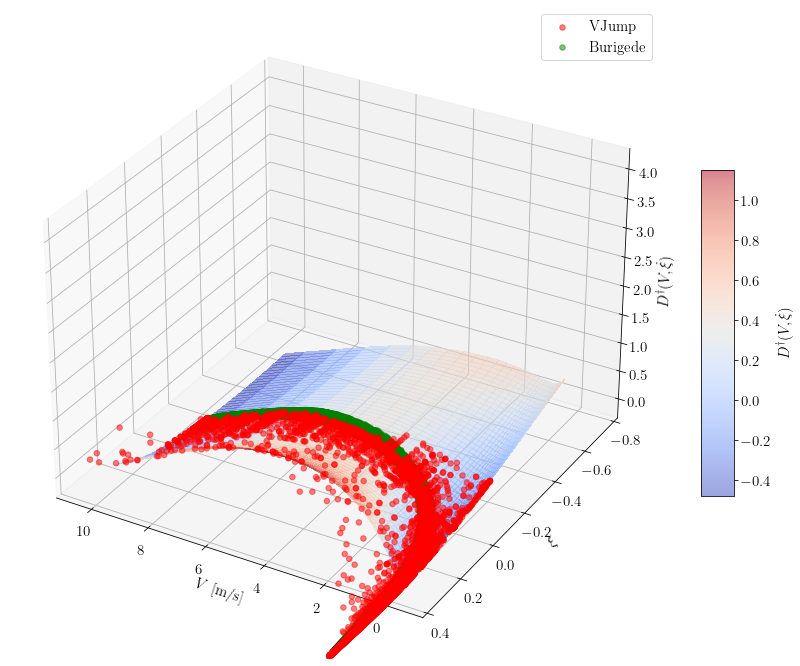

In [11]:
# Compute values for the 2D map
DotX, Xi = np.meshgrid(dotX, xi)
logVFlag = False

# Initialize the plot
fig, ax = plt.subplots(figsize = (15, 12), subplot_kw={"projection": "3d"})
ax.view_init(elev=30, azim=120)

for idx in range(len(legends)):
    # Scatter the supporting points
    D_dagger_dataPts = torch.stack([torch.from_numpy(Vss[idx]).float(), torch.from_numpy(xiss[idx]).float()], dim=1)
    D_dagger_dataPts_val = torch.squeeze(myPotCal.D_dagger(D_dagger_dataPts))
    D_dagger_dataPts_val = D_dagger_dataPts_val.detach().numpy()
    
    # Scatter the data points first
    if logVFlag:
        Vin = np.log10(D_dagger_dataPts[:, 0])
    else:
        Vin = D_dagger_dataPts[:, 0]

    ax.scatter(Vin, 
            D_dagger_dataPts[:, 1], 
            D_dagger_dataPts_val, 
            s=30, 
            marker="o", 
            alpha=0.5, 
            c=colors[idx], 
            label=legends[idx])

ax.legend(fontsize=fsize)

# Plot the surface
D_dagger_input = torch.stack([torch.from_numpy(DotX).float(), torch.from_numpy(Xi).float()], dim=2)
D_dagger_val = torch.squeeze(myPotCal.D_dagger(D_dagger_input))
D_dagger_val = D_dagger_val.detach().numpy()
print("Range of D_dagger: ", min(D_dagger_val.flatten()), ", ", max(D_dagger_val.flatten()))

# Plot the surface.
if logVFlag:
    Vin = np.log10(DotX)
else:
    Vin = DotX

surf = ax.plot_surface(Vin, Xi, D_dagger_val, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.5)

ax.set_xlim(-1, 11)
ax.set_ylim(-0.8, 0.4)
ax.set_zlim(-0.25, 4.25)

if logVFlag:
    ax.set_xlabel("$\log_{10}(V)$ [m/s]", fontsize=fsize)
else:
    ax.set_xlabel("$V$ [m/s]", fontsize=fsize)
ax.set_ylabel("$\dot{\\xi}$",fontsize=fsize)
ax.set_zlabel("$D^\dagger(V, \dot{\\xi})$", fontsize=fsize)

# Add a color bar which maps values to colors.
cb = fig.colorbar(surf, shrink=0.5, aspect=10)
cb.set_label("$D^\dagger(V, \dot{\\xi})$", fontsize=fsize)
cb.ax.tick_params(labelsize=fsize)
ax.tick_params(axis='both', which='major', labelsize=fsize)

plt.show()

In [55]:
ax.initial_

-60

# Plot $W(x)$

Text(0, 0.5, '$W(x)$')

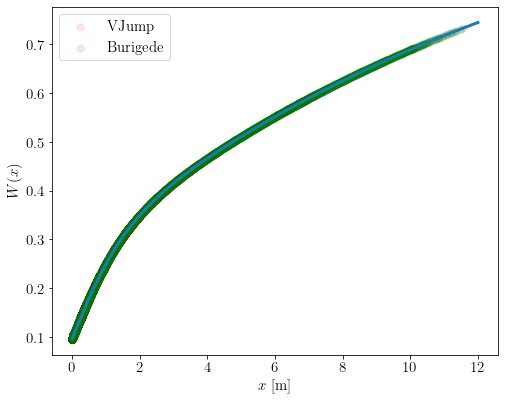

In [12]:
# Plot W(x)
W_val = myPotCal.W(torch.from_numpy(x).float().reshape([-1, 1])).reshape(-1).detach().numpy()


fig, ax = plt.subplots(figsize = (8, 6.4))
ax.tick_params(axis='both', which='major', labelsize=fsize)

# Scatter all supporting datapoints
for idx in range(len(legends)):
    W_dataPts = myPotCal.W(torch.from_numpy(Xss[idx]).float().reshape([-1, 1])).reshape(-1).detach().numpy()
    ax.scatter(Xss[idx], W_dataPts, s=50, marker="o", alpha=0.1, c=colors[idx], label=legends[idx])
ax.legend(fontsize=fsize)

# Plot the curve
ax.plot(x, W_val, linewidth=3.0)

ax.set_xlabel("$x$ [m]", fontsize=fsize)
ax.set_ylabel("$W(x)$", fontsize=fsize)

# 

# Plot $D^*(\dot{d})$

Text(0, 0.5, '$D^*(\\dot{d})$')

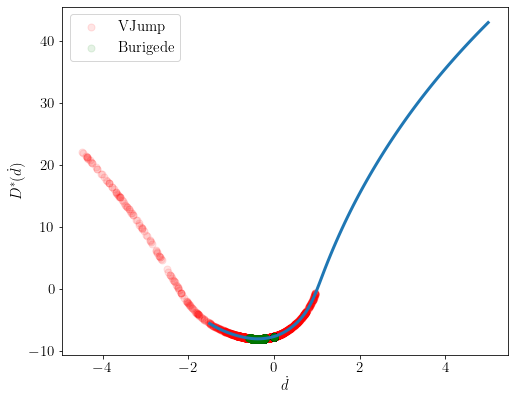

In [13]:
# Plot D^*(\dot{d})
Dstar_val = myPotCal.D(torch.from_numpy(Din).float().reshape([-1, 1])).reshape(-1).detach().numpy()

fig, ax = plt.subplots(figsize = (8, 6.4))
ax.tick_params(axis='both', which='major', labelsize=fsize)

# Scatter all supporting datapoints
for idx in range(len(legends)):
    Dstar_dataPts = myPotCal.D(torch.from_numpy(Dinss[idx]).float().reshape([-1, 1])).reshape(-1).detach().numpy()
    ax.scatter(Dinss[idx], Dstar_dataPts, s=50, marker="o", alpha=0.1, c=colors[idx], label=legends[idx])
ax.legend(fontsize=fsize)

# Plot the curve
ax.plot(Din, Dstar_val, linewidth=3.0)

ax.set_xlabel("$\dot{d}$", fontsize=fsize)
ax.set_ylabel("$D^*(\dot{d})$", fontsize=fsize)

# Get distributions of 

In [ ]:
# 